Copyright **`(c)`** 2023 Alessandro Chiabodo `<s309234@studenti.polito.it>`  
[`github.com/AChiabodo`](https://github.com/AChiabodo)   

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [52]:
import random
from copy import deepcopy
import pickle
import math
import numpy as np
from enum import Enum
import lab3_lib
from lab3_lib import AbstractProblem
from itertools import chain
import matplotlib.pyplot as plt
from collections.abc import Callable

### Interface for the Agents
This class includes all the methods that an agent must implement in order to be used by the framework, and some utility functions common to all Agents.

In [53]:
class Agent():

    class Crossover(Enum):
        RANDOM = 1
        MULTI_CUT = 2
        ONE_CUT = 3
        PARTIAL = 4

    class AgentType(Enum):
        BINARY = 1
        PATTERN = 2

    def __init__(self,genome,mutation_rate : float = None) -> None:
        self.genome = genome
        self.mutation_rate = mutation_rate
        self._id = random.randint(0, 1000000000)
        self._fitness = None
        self._hash = None
        pass

    def set_mutation_rate(self, mutation_rate : float) -> None:
        self.mutation_rate = mutation_rate

    def set_genome(self, genome) -> None:
        self.genome = genome

    def set_fitness(self, fitness) -> None:
        self._fitness = fitness

    def compute_fitness(self,fitness_function) -> None:
        if self.genome is None:
            ValueError("Genome is not set")
        self._fitness = fitness_function(self.genome)
        pass  

    def mutation(self,mutation_rate) -> None:
        if self.genome is None:
            ValueError("Genome is not set")
        if mutation_rate is None and self.mutation_rate is None:
            ValueError("Mutation rate is not set")
        if self.mutation_rate is not None and mutation_rate is None:
            self.mutation_rate *= [0.999,1.001][random.randint(0,1)]
        pass      

    @property
    def fitness(self):
        if self._fitness is None:
            self.compute_fitness()
        return self._fitness

    @property
    def hash(self):
        if self.genome is None:
            ValueError("Genome is not set")
        if self._hash is None:
            self._hash = hash(tuple(self.genome))
        return self._hash

    def load_agent(self, path):
        with open(path, 'rb') as f:
            self.genome = pickle.load(f)
        return self
    
    def save_agent(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.genome, f)

#### BinaryGenome Agent

In [54]:
class AgentGA(Agent):

    def __init__(self) -> None:
        super().__init__(None,None)

    def set_genome(self,genome_size : int,genome : list = None) -> 'AgentGA':
        if genome is None:
            genome = [random.uniform(0, 1) < 0.5 for _ in range(genome_size)]
        super().set_genome(genome)
        
        return self

    def set_mutation_rate(self,mutation_rate : float) -> 'AgentGA':
        super().set_mutation_rate(mutation_rate)

        return self

    def mutation(self,mutation_rate : float = None) -> 'AgentGA':
        super().mutation(mutation_rate)

        mask = [random.uniform(0, 1) < (mutation_rate if mutation_rate is not None else self.mutation_rate) for _ in range(len(self.genome))]
        self.genome = [a ^ b for a, b in zip(self.genome, mask)]
        return self

    def __repr__(self) -> str:
        return f"AgentGA({self._id},{self.fitness})"

    def crossover(self,other : 'AgentGA',crossover_type : Agent.Crossover = Agent.Crossover.RANDOM,other_weight = 0.5) -> Agent:
        match crossover_type:
            case Agent.Crossover.RANDOM:
                return self.random_crossover(other,other_weight)
            case Agent.Crossover.MULTI_CUT:
                return self.multi_cut_crossover(other)
            case Agent.Crossover.ONE_CUT:
                return self.one_cut_crossover(other)
            case Agent.Crossover.PARTIAL:
                return self.partial_cut_crossover(other)
            case _:
                raise ValueError("Unknown crossover type")

    def random_crossover(self,other : Agent,other_weight = 0.5) -> Agent:

        for (i,_) in enumerate(self.genome):
            self.genome[i] = random.choices([self.genome[i],other.genome[i]],weights=[1-other_weight,other_weight])[0]
        return self
    
    def multi_cut_crossover(self,other : Agent) -> Agent:

        n = random.randint(1, len(self.genome)//2-1)
        size = len(self.genome)//n
        for i in range(n):
            start = i * size
            end = (i + 1) * size - 1
            n = random.randint(start, end)
            m = random.randint(start, end)
            if n > m:
                n,m = m,n
            self.genome[n:m] = other.genome[n:m]
        return self

    def one_cut_crossover(self,other : 'AgentGA') -> 'AgentGA': #TODO rewrite and rename as One Point Crossover

        n = random.randint(0, len(self.genome)-1)
        self.genome[n:] = other.genome[n:]
        return self
    
    def partial_cut_crossover(self,other : 'AgentGA') -> 'AgentGA':

        n = random.randint(0, len(self.genome)-1)
        m = random.randint(0, len(self.genome)-1)
        if n > m:
            n,m = m,n
        self.genome[n:m] = other.genome[n:m]
        return self

    def compute_fitness(self,fitness_function : AbstractProblem) -> None:
        super().compute_fitness(fitness_function)
        

#### PatternGenome Agent

In [55]:
class PatternBasedAgent(Agent):

    def __init__(self) -> None:
        #self.pattern_size = random.randint(1,genome_size//10)
        super().__init__(None,None)
        
    def set_genome(self,genome_size : int,genome : list = None) -> 'PatternBasedAgent':
        self.genome_size = genome_size
        self.pattern_size = random.randint(genome_size//50,genome_size//5)
        self.pattern = [random.uniform(0, 1) < 0.5 for _ in range(self.pattern_size)]
        self.generate_genome()
        return self
    
    def set_mutation_rate(self,mutation_rate : float) -> 'PatternBasedAgent':
        super().set_mutation_rate(mutation_rate)
        self._pattern_mutation_rate = min(mutation_rate * self.pattern_size / 10 , 0.2)
        return self

    # should be called generate_phenotype 
    def generate_genome(self):
        self.genome = list(chain.from_iterable([self.pattern for _ in range(self.genome_size//self.pattern_size + 1)])) # overshoot the size to be sure to have enough
        self.genome = self.genome[:self.genome_size]
        #print(f"size : {self.pattern_size} with pattern : {self.pattern} , genome : {self.genome}")

    def mutation(self,mutation_rate : float = None) -> 'PatternBasedAgent':
        super().mutation(mutation_rate)

        ###### mutate the pattern_size
        if random.random() < (self._pattern_mutation_rate if mutation_rate is None else mutation_rate * 10) :
            adding = random.choices([-1, 1], weights=[1, 2])[0]
            if adding == -1 and self.pattern_size > 1:
                self.pattern_size -= 1
                self.pattern = self.pattern[:-1]
            else:
                temp = random.choices([0, 1], k = adding)
                self.pattern_size += adding
                self.pattern += temp

        ###### mutate the pattern
        for (i,state) in enumerate(self.pattern):
            if random.random() < (mutation_rate if mutation_rate is not None else self.mutation_rate) :
                self.pattern[i] = not state
        self.generate_genome()
        return self

    def __repr__(self) -> str:
        return f"AgentGA({self._id},{self.fitness}) with pattern {self.pattern}"

    def crossover(self,other : 'PatternBasedAgent',crossover_type : Agent.Crossover = 1,other_weight = 0.5) -> 'PatternBasedAgent':
        match crossover_type:
            case Agent.Crossover.RANDOM:
                self.random_crossover(other,other_weight)
            case Agent.Crossover.MULTI_CUT:
                self.multi_cut_crossover(other)
            case Agent.Crossover.ONE_CUT:
                self.one_cut_crossover(other)
            case Agent.Crossover.PARTIAL:
                self.partial_crossover(other)
            case _:
                raise ValueError("Unknown crossover type")
        self.generate_genome()
        return self

    def random_crossover(self,other : 'PatternBasedAgent',other_weight = 0.5) -> 'PatternBasedAgent':
        """ Implements a random crossover between self and an other Agent (of the same type)"""

        offset = self.pattern_size - other.pattern_size
        if offset > 0:
            temp = random.randint(0,offset)
            for (i,_) in enumerate(other.pattern):
                self.pattern[i + temp] = random.choices([self.pattern[i + temp],other.pattern[i]],weights=[1-other_weight,other_weight])[0]
        else:
            temp = random.randint(0,abs(offset))
            for (i,_) in enumerate(self.pattern):
                self.pattern[i] = random.choices([self.genome[i],other.genome[i + temp]],weights=[1-other_weight,other_weight])[0]
        return self
    
    def multi_cut_crossover(self,other : 'PatternBasedAgent') -> 'PatternBasedAgent':
        """ Implements a multi cut crossover between self and an other Agent (of the same type)"""

        for _ in range(random.randint(0, (min(self.pattern_size , other.pattern_size) - 1)//2)):
            n = random.randint(0, min(self.pattern_size , other.pattern_size) - 1)
            m = random.randint(0, min(self.pattern_size , other.pattern_size) - 1)
            if n > m:
                n,m = m,n
            self.pattern[n:m] = other.pattern[n:m]
        
        return self

    def one_cut_crossover(self, other: 'PatternBasedAgent') -> 'PatternBasedAgent':
        min_length = min(self.pattern_size, other.pattern_size)
        n = random.randint(0, min_length - 1)

        self.pattern[:min_length-n] = other.pattern[:min_length-n]
    
    def partial_crossover(self,other : 'PatternBasedAgent') -> 'PatternBasedAgent':

        RuntimeError("Not yet implemented")
        n = random.randint(0, len(self.genome)-1)
        m = random.randint(0, len(self.genome)-1)
        if n > m:
            n,m = m,n
        self.genome[n:m] = other.genome[n:m]
        return self

    def compute_fitness(self,fitness_function : AbstractProblem) -> None:
        super().compute_fitness(fitness_function)
    
    @property
    def fitness(self):
        return self._fitness

In [56]:
def calculate_entropy(agent_list): #TODO rewrite
    # Calcola la probabilità di ciascun agente rispetto al totale
    total_agents = len(agent_list)
    probabilities = [agent.fitness / total_agents for agent in agent_list]

    # Calcola l'entropia utilizzando la formula di Shannon
    entropy = -sum(p * math.log2(p) if p > 0 else 0 for p in probabilities)

    return entropy

In [57]:
class TrainingTypes(Enum):
    EVOLUTIONARY_STRATEGY = 1
    TOURNAMENT = 2

In [58]:
class AgentIslandsTraining():

    def __init__(
            self, 
            pop_size : int,
            problem  : AbstractProblem,
            k : int = 1000,
            islands_number : int = 10,
            agent_type : Agent.AgentType = Agent.AgentType.BINARY
        ) -> None:
        
        self.problem = problem
        self._starting_mutation_rate = 0.008
        self._fitness_dict = {}
        self.mutation_rate = self._starting_mutation_rate

        self.generation : Callable = None
        self._old_fitness = None
        self._static_epochs = 0
        self._islands = [ [] for _ in range(islands_number)]
        self._island_population = pop_size // islands_number
        self._random_restart_probability = 0
        self._agent : Agent = None
        self._pop_size = pop_size
        self._islands_number = islands_number
        print("Creating Islands")
        print(f"Islands : {self._islands}")

        match agent_type:
            case Agent.AgentType.BINARY:
                self._agent = AgentGA
            case Agent.AgentType.PATTERN:
                self._agent = PatternBasedAgent
            case _:
                raise ValueError("Unknown agent type")
        
        #Population Initialization
        for island in self._islands:
            for _ in range(pop_size // islands_number):
                temp : Agent = self._agent().set_genome(genome_size=k).set_mutation_rate(random.uniform(0.001, 0.006))
                self.update_fitness_dict(temp)
                island.append(temp)
            print(f"Islands : {[len(x) for x in self._islands]}")

    def update_fitness_dict(self,agent : Agent):
        fit = self._fitness_dict.get(tuple(agent.genome))
        if fit is None:
            agent.compute_fitness(self.problem)
            self._fitness_dict[tuple(agent.genome)] = agent.fitness
        else:
            agent.set_fitness(fit)
       
    @staticmethod
    def average_rule(agent_list : list[Agent]):
        # Calcola la media delle regole di tutti gli agenti
        total_agents = len(agent_list)
        total_rules = len(agent_list[0].genome)
        average = [0 for _ in range(total_rules)]

        for agent in agent_list:
            for i in range(total_rules):
                average[i] += agent.genome[i]

        average = [x / total_agents for x in average]

        return average

    def generation_ES(self) -> None:
        for i , island in enumerate(self._islands):      
            size = len(island)
            for _ in range(self._lam):
                #parent , other = random.choices(island,weights=[x.fitness for x in island],k=2)
                parent , other = random.choices(island,k=2)
                parent = deepcopy(parent)
                if random.random() > self.ration :
                    parent.crossover(other,Agent.Crossover.ONE_CUT)
                parent.mutation()
                self.update_fitness_dict(parent)
                island.append(parent)    
            island.sort(key=lambda x : x.fitness , reverse=True)
            self._islands[i] = island[:size]
            if self._random_restart_probability > random.random():
                self._islands[i][-1] = self._agent().set_genome(genome_size=len(self._islands[i][-1].genome)).set_mutation_rate(random.uniform(0.001, 0.006))
                self.update_fitness_dict(self._islands[i][-1])
                self._random_restart_probability = 0.9 * self._random_restart_probability
    
    def generation_tournament(self) -> None:
        for i , island in enumerate(self._islands):      
            current_member = 0
            mating_pool = []
            while current_member < self._mating_pool_size:
                tournament = random.choices(island,k=self._tournament_size)
                tournament.sort(key=lambda x : x.fitness , reverse=True)
                mating_pool.append(tournament[0])
                current_member += 1
            temp_population = []
            for parent in mating_pool:
                for _ in range(self._lam // self._mating_pool_size):
                    temp : Agent = deepcopy(parent).mutation()
                    self.update_fitness_dict(temp)
                    temp_population.append(temp)
            size = len(island)
            self._islands[i].extend(temp_population)
            self._islands[i].sort(key=lambda x : x.fitness , reverse=True)
            self._islands[i] = self._islands[i][:size]
            #self._islands[i][-self._mating_pool_size:] = temp_population[:self._mating_pool_size]
                
    def migration(self , N : int = 1):
        """
        Migrate N agents from each island to the next one in a circular fashion. Note that if we have only one island, this function does nothing.
        
        Parameters:
        - N (int): The number of agents to migrate from each island (default: 1).
        """
        
        if len(self._islands) == 1:
            return
        for i in range(len(self._islands)-1) :
            for _ in range(N):
                pos_1 = random.randint(0,len(self._islands[i]) - 1)
                pos_2 = random.randint(0,len(self._islands[(i+1)%len(self._islands)]) - 1)
                self._islands[i][pos_1] , self._islands[(i+1)%len(self._islands)][pos_2] =  self._islands[(i+1)%len(self._islands)][pos_2] , self._islands[i][pos_1]

    def train(self,
            generations = 10,
            training_type : TrainingTypes = TrainingTypes.EVOLUTIONARY_STRATEGY,
            lam : int = None,
            mating_pool_size : int = None,
            tournament_size : int = None
        ):
        """
        Trains the model using the specified training type and parameters.

        Parameters:
        - generations (int): The number of generations to train the model (default: 10).
        - training_type (TrainingTypes): The type of training to use (default: TrainingTypes.EVOLUTIONARY_STRATEGY).
        - lam (int): The number of offsprings generated at each interaction (default: None).
        - mating_pool_size (int): The size of the mating pool for tournament training type (default: None).
        - tournament_size (int): The size of the tournament for tournament training type (default: None).
        Returns:
        - None
        """

        self.ration = 0.8
        match training_type:
            case TrainingTypes.EVOLUTIONARY_STRATEGY:
                self.generation = self.generation_ES
                self._lam = lam if lam is not None else self._pop_size // self._islands_number
            case TrainingTypes.TOURNAMENT:
                self.generation = self.generation_tournament
                self._mating_pool_size = mating_pool_size if mating_pool_size is not None else (self._pop_size // self._islands_number) // 2
                self._lam = lam if lam is not None else (self._pop_size // self._islands_number) // self._mating_pool_size
                self._tournament_size = tournament_size if tournament_size is not None else 4
        
        best_fitness = None
        fitnesses = []
        print("Starting Training")
        for gen in range(generations):
            
            self.generation()
            best_fitness = max([agent for island in self._islands for agent in island], key=lambda agent: agent.fitness)
            fitnesses.append(best_fitness.fitness)
            
            if (gen + 1 ) % 10 == 0:
                self.migration(self._island_population // 10) #migrate 10% of the population
                if self._old_fitness == best_fitness:
                    self._static_epochs += 1
                    self._random_restart_probability = 0.9 * self._random_restart_probability + 0.1
                else:
                    self._static_epochs = 0
                    self._old_fitness = best_fitness
                    self._random_restart_probability = 0
                if self._static_epochs > 2:
                    self.mutation_rate = min(self._starting_mutation_rate,1.05 * self.mutation_rate)
                else:
                    self.mutation_rate = max(self._starting_mutation_rate/10,0.95 * self.mutation_rate)
                    self.ration = max(0.4,0.99 * self.ration)
                print(f"Best fitness : {best_fitness.fitness} at gen {gen+1} with criterion : {self.ration} , mutation : {best_fitness.mutation_rate} , static_epochs : {self._static_epochs}")
                temp = self.average_rule([agent for island in self._islands for agent in island])
                print(f"Average sum : {sum(temp) / 1000} , rule weight : {temp}")

            if best_fitness is not None and best_fitness.fitness == 1.0:
                break
        
        return best_fitness , fitnesses

Creating Islands
Islands : [[], [], [], [], []]
Islands : [120, 0, 0, 0, 0]
Islands : [120, 120, 0, 0, 0]
Islands : [120, 120, 120, 0, 0]
Islands : [120, 120, 120, 120, 0]
Islands : [120, 120, 120, 120, 120]
Starting Training
Best fitness : 0.62342 at gen 10 with criterion : 0.792 , mutation : 0.0049918053958715345 , static_epochs : 0
Average sum : 0.5942650000000002 , rule weight : [0.5583333333333333, 0.8383333333333334, 0.8183333333333334, 0.715, 0.6383333333333333, 0.4766666666666667, 0.6983333333333334, 0.83, 0.655, 0.61, 0.5766666666666667, 0.62, 0.7883333333333333, 0.6533333333333333, 0.5516666666666666, 0.48333333333333334, 0.47833333333333333, 0.49, 0.6283333333333333, 0.425, 0.7583333333333333, 0.6066666666666667, 0.455, 0.57, 0.6216666666666667, 0.45, 0.4633333333333333, 0.3516666666666667, 0.6116666666666667, 0.4033333333333333, 0.5033333333333333, 0.71, 0.6433333333333333, 0.66, 0.6866666666666666, 0.8316666666666667, 0.7166666666666667, 0.715, 0.5333333333333333, 0.46, 0.

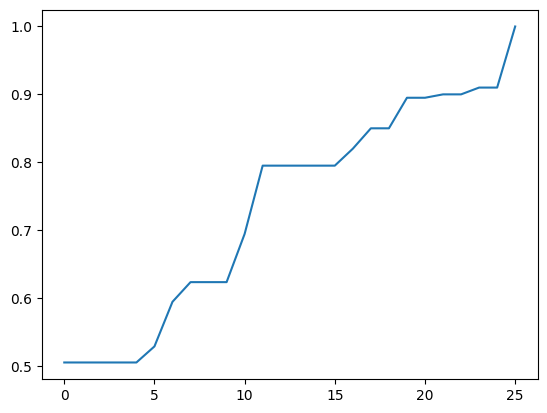

In [59]:
fitness = lab3_lib.make_problem(10)
trainer = AgentIslandsTraining(pop_size=600,problem=fitness,k=1000,islands_number=5,agent_type=Agent.AgentType.PATTERN)
best_agent , fitnesses = trainer.train(1000,training_type=TrainingTypes.EVOLUTIONARY_STRATEGY,lam=100,mating_pool_size=50,tournament_size=4)
print(best_agent)
print(fitness.calls)
plt.plot(fitnesses)

#### A dumb approach to the problem
Trying to optimize the problem by trying to maximize the fitness bit-by-bit, converge almost instantly for n = 1, but can't find anything with 2,5,10 problem size

In [60]:
def dummy_solution(fitness):
    k = 1000
    agent_slighly_smarter = [random.uniform(0,1) < 0.5 for _ in range(k)]
    agent_fitness = fitness(agent_slighly_smarter)
    while agent_fitness < 1.0:
        for i in range(k):
            temp = deepcopy(agent_slighly_smarter)
            temp[i] = not temp[i]
            temp_fitness = fitness(temp)
            if temp_fitness > agent_fitness:
                agent_slighly_smarter = temp
                agent_fitness = temp_fitness
        print(agent_fitness)
    #print(fitness(agent_slighly_smarter))
    #print(fitness.calls)
    return agent_slighly_smarter
fitness = lab3_lib.make_problem(1)
print(fitness(dummy_solution(fitness)))

1.0
1.0


#### Hill Climbing approach
Using a "basic" local-search approach like Hill Climbing, we can find a solution for n = 1 with a very low number of calls to the fitness function, but it's unable to find anything for n = 2,5,10

In [61]:
def hill_climbing(k : int,fitness : AbstractProblem,lam) -> [Agent, list]:
    agent = AgentGA().set_genome(genome_size=k,genome=[random.uniform(0,1) < 0.5 for _ in range(k)])
    agent.compute_fitness(fitness)
    gen = 0
    gene_modifier = 2
    mutation_rate = gene_modifier / k
    fitnesses = []
    while agent.fitness < 1.0 and gen < 1000:
        offspring = []
        for _ in range(lam):
            agent_temp = deepcopy(agent)
            agent_temp.mutation(mutation_rate)
            agent_temp.compute_fitness(fitness)
            offspring.append(agent_temp)
        offspring.append(agent)
        offspring.sort(key=lambda x : x.fitness , reverse=True)
        agent = offspring[0]
        fitnesses.append(agent.fitness)
        gen += 1
        if gen % 10 == 0:
            print(f"gen {gen} : Best fitness : {agent.fitness}")
    return agent , fitnesses

gen 10 : Best fitness : 0.547
gen 20 : Best fitness : 0.566
gen 30 : Best fitness : 0.588
gen 40 : Best fitness : 0.608
gen 50 : Best fitness : 0.634
gen 60 : Best fitness : 0.653
gen 70 : Best fitness : 0.671
gen 80 : Best fitness : 0.687
gen 90 : Best fitness : 0.708
gen 100 : Best fitness : 0.721
gen 110 : Best fitness : 0.746
gen 120 : Best fitness : 0.764
gen 130 : Best fitness : 0.781
gen 140 : Best fitness : 0.794
gen 150 : Best fitness : 0.806
gen 160 : Best fitness : 0.816
gen 170 : Best fitness : 0.827
gen 180 : Best fitness : 0.835
gen 190 : Best fitness : 0.845
gen 200 : Best fitness : 0.852
gen 210 : Best fitness : 0.859
gen 220 : Best fitness : 0.869
gen 230 : Best fitness : 0.876
gen 240 : Best fitness : 0.882
gen 250 : Best fitness : 0.889
gen 260 : Best fitness : 0.898
gen 270 : Best fitness : 0.903
gen 280 : Best fitness : 0.911
gen 290 : Best fitness : 0.915
gen 300 : Best fitness : 0.919
gen 310 : Best fitness : 0.926
gen 320 : Best fitness : 0.929
gen 330 : Best fi

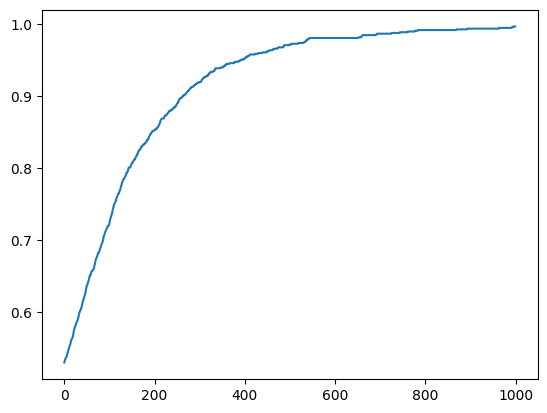

In [62]:
fitness = lab3_lib.make_problem(1)
agent , fitnesses = hill_climbing(1000,fitness,20)
fitness.calls
plt.plot(fitnesses)